In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, QuantileTransformer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoTokenizer, RobertaForSequenceClassification
import torch
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.impute import SimpleImputer

2024-11-15 09:44:53.419155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 09:44:53.462779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 09:44:53.462803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 09:44:53.464205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 09:44:53.472583: I tensorflow/core/platform/cpu_feature_guar

In [2]:
outflows = pd.read_parquet('data/outflows.pqt')
outflows.posted_date = pd.to_datetime(outflows.posted_date, format='%Y-%m-%d')

categories = ['GENERAL_MERCHANDISE', 'FOOD_AND_BEVERAGES', 'GROCERIES', 'TRAVEL', 'PETS', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION', 'RENT']
outflows = outflows[outflows.category.isin(categories)]

In [3]:
outflows['new_memo'] = outflows.memo.str.lower().str.replace(r'\*(\S)', r' \1', regex=True)     # Remove all '*' but gotta check if there's any alphanumerics right after it
outflows['new_memo'] = outflows.new_memo.str.replace(r'[^a-z0-9]', ' ', regex=True)             # Remove all special chars (besides .)
outflows['new_memo'] = outflows.new_memo.str.replace(r'x{3,}', ' ', regex=True)                 # Remove all triple X's
outflows['new_memo'] = outflows.new_memo.str.replace(r'withdrawal', 'withdrawal ', regex=True)  # Fixing the withdrawal rows
outflows['new_memo'] = outflows.new_memo.str.replace(r'purchase', 'purchase ', regex=True)      # Fixing the purchase rows
outflows['new_memo'] = outflows.new_memo.str.replace(r'\s+', ' ', regex=True).str.strip()       # Remove any extra whitespace

outflows = outflows[['prism_consumer_id', 'prism_account_id', 'memo', 'new_memo', 'amount',	'posted_date', 'category']]
outflows[['memo', 'new_memo']]

,memo,new_memo
2,TST* Casa Del Rio - Exp Fairlawn OH 09/24,tst casa del rio exp fairlawn oh 09 24
4,Buffalo Wild Wings,buffalo wild wings
6,Oculus CA 04/16,oculus ca 04 16
7,LOS GIRASOLES STOW OH 03/08,los girasoles stow oh 03 08
8,BUZZIS LAUNDRY 1 OH 03/28,buzzis laundry 1 oh 03 28
...,...,...
2597457,DEBIT CARD WITHDRAWAL PURCHASEAmazon Prime*TI4...,debit card withdrawal purchase amazon prime ti...
2597462,POS WITHDRAWALAZ LOT QUIKTRIP XXXX XXXX E INDI...,pos withdrawal az lot quiktrip e indian school...
2597465,POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS ...,pos withdrawal wal mart e mckellips rd mesa az...
2597468,WITHDRAWAL Salt River ProjeTYPE: ONLINE PMT CO...,withdrawal salt river projetype online pmt co ...


In [4]:
outflows.category.value_counts(normalize=True) * 100

category
GENERAL_MERCHANDISE    40.113452
FOOD_AND_BEVERAGES     36.893357
GROCERIES              16.788294
TRAVEL                  4.565571
PETS                    0.709249
EDUCATION               0.344368
OVERDRAFT               0.259175
RENT                    0.240881
MORTGAGE                0.085652
Name: proportion, dtype: float64

In [5]:
outflows.category.value_counts()

category
GENERAL_MERCHANDISE    524063
FOOD_AND_BEVERAGES     481994
GROCERIES              219331
TRAVEL                  59647
PETS                     9266
EDUCATION                4499
OVERDRAFT                3386
RENT                     3147
MORTGAGE                 1119
Name: count, dtype: int64

In [6]:
outflows.drop(columns='memo', inplace=True)

## Data Splitting:

In [7]:
np.random.seed(42069)

# Splitting based on prism_consumer_id:
cids = outflows.prism_consumer_id.unique()
train_cids, test_cids = train_test_split(cids, test_size=0.3, random_state=420) # 70 / 30 split

# Features and labels for train and test sets:
X_train = outflows[outflows.prism_consumer_id.isin(train_cids)]
X_test  = outflows[outflows.prism_consumer_id.isin(test_cids)]

y_train = X_train.category
y_test  = X_test.category

len(X_train), len(X_test)

(922256, 384196)

## Feature Engineering:

- posted_date based:

In [8]:
X_train['month_name'] = X_train.posted_date.dt.month_name()
X_train['day_name'] = X_train.posted_date.dt.day_name()

X_train = pd.get_dummies(X_train, columns=['month_name', 'day_name'])

/tmp/ipykernel_4064/316536858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month_name'] = X_train.posted_date.dt.month_name()
/tmp/ipykernel_4064/316536858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day_name'] = X_train.posted_date.dt.day_name()


- amount based:

In [9]:
def is_whole(num):
    return num % 1 == 0

In [10]:
X_train['is_whole_num'] = X_train.amount.apply(is_whole)

In [11]:
X_train

,prism_consumer_id,prism_account_id,new_memo,amount,posted_date,category,month_name_April,month_name_August,month_name_December,month_name_February,...,month_name_October,month_name_September,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,is_whole_num
2,0,acc_0,tst casa del rio exp fairlawn oh 09 24,18.42,2022-09-26,FOOD_AND_BEVERAGES,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
4,0,acc_0,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
6,0,acc_0,oculus ca 04 16,11.73,2022-04-18,GENERAL_MERCHANDISE,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7,0,acc_0,los girasoles stow oh 03 08,30.04,2022-03-09,FOOD_AND_BEVERAGES,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,0,acc_0,buzzis laundry 1 oh 03 28,4.16,2022-03-29,GENERAL_MERCHANDISE,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597457,5941,acc_9524,debit card withdrawal purchase amazon prime ti...,15.93,2023-01-16,GENERAL_MERCHANDISE,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2597462,5941,acc_9524,pos withdrawal az lot quiktrip e indian school...,25.00,2023-01-18,EDUCATION,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2597465,5941,acc_9524,pos withdrawal wal mart e mckellips rd mesa az...,3.68,2023-01-18,FOOD_AND_BEVERAGES,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2597468,5941,acc_9524,withdrawal salt river projetype online pmt co ...,90.00,2023-01-20,FOOD_AND_BEVERAGES,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


## Hybrid Classifier (Rule-Based and Logisitic Regression w/ TF-IDF Features):

## Facts from Years 2017-2023:
### 1. **Taxes**
   - **Income Taxes (U.S.):** Still typically due on **April 15** each year, except when April 15 falls on a weekend or holiday (when it’s moved to the next business day). 
     - There were some exceptions in 2020 and 2021 due to the COVID-19 pandemic:
       - **2020 (for 2019 taxes):** The deadline was extended to **July 15, 2020**.
       - **2021 (for 2020 taxes):** The deadline was extended to **May 17, 2021**.
   - **Property Taxes:** Due dates for property taxes generally remained the same, varying by state or county. Many areas continued to have semiannual or annual payment deadlines, often in **March, September,** or **November**.

### 2. **Rent**
   - Rent due dates have consistently been on the **first of the month**. This standard practice hasn't changed, although individual landlords or properties might have made temporary adjustments in 2020 and 2021 to accommodate COVID-19-related hardships. Some cities and states had temporary eviction moratoriums, allowing renters more flexibility in paying.

### 3. **Mortgage**
   - Mortgage payments are still generally due on the **first of the month**, with a typical grace period until the 15th. This standard has not changed in recent years.
   - In 2020 and 2021, there were temporary mortgage forbearance programs in the U.S. as part of COVID-19 relief efforts, allowing some borrowers to defer payments without penalties. However, the due dates for regular payments remained the same once the forbearance periods ended.

### 4. **Education Fees for College/School**
   - **Semester Deadlines:** Still typically due in **July or August** for the fall semester and **December or January** for the spring semester. These deadlines have been consistent for many years.
   - **Monthly or Quarterly Payment Plans:** Institutions continue to offer these options for spreading payments over several months, typically with the first payment due a month or two before the semester starts.
   - During 2020, some institutions provided more flexible payment options due to the pandemic, but the overall payment schedules were largely unchanged.

In [12]:
# [memo for memo in outflows[(outflows.category == 'GROCERIES')&(~outflows.new_memo.str.contains('groceries'))]['new_memo'].values]

## Self-Observed Features:
    - TST = Food & Beverages
    - POS: tells you it's not a check, but that's about it
    - OVERDRAFT: memo will state if a transaction is overdraft (transaction causes an account to have a balance of zero/under zero)
    - PETS: will say pets/pet store names
    - EDUCATION: will contain school, college, university, etc.
    - Nov/Dec = GM
    - Apr/May = Taxes, Rent, etc.
    - Summer = a lot of people are traveling

- looking at keywords in memos for obvious categorizations:

In [13]:
category_keywords = {
    'GENERAL_MERCHANDISE': ['store', 'mart'],
    'FOOD_AND_BEVERAGES': ['tst'],
    'GROCERIES': ['groceries', 'supermarket', 'market'],
    'TRAVEL': [r'airline|airlines', 'airpt', 'flight', 'hotel', 'travel', 'uber', 'lyft', 'inn'],
    'PETS': ['vet', 'pet', 'pets', 'animal', 'grooming'],
    'MORTGAGE': ['mortgage', 'home', 'house', 'mtg', 'mortg'],
    'OVERDRAFT': ['overdraft', 'insufficient', 'nsf', 'overdrawn'],
    'EDUCATION': ['tuition', 'school', 'university', 'course', 'book', 'books', 'college'],
    'RENT': ['rent']
}

def classify_memo(memo):
    for category, patterns in category_keywords.items():
        for pattern in patterns:
            if re.search(pattern, memo):
                return category
    return 'UNCATEGORIZED'  # Fallback if no keywords match

### Using model on training set:

In [14]:
columns_to_passthrough = [
    'month_name_April', 'month_name_August', 'month_name_December',
    'month_name_February', 'month_name_January', 'month_name_July',
    'month_name_June', 'month_name_March', 'month_name_May',
    'month_name_November', 'month_name_October', 'month_name_September',
    'day_name_Friday', 'day_name_Monday', 'day_name_Saturday',
    'day_name_Sunday', 'day_name_Thursday', 'day_name_Tuesday',
    'day_name_Wednesday', 'is_whole_num'
]

In [15]:
# Apply rule-based classification to categorize entries initially
X_train['pred'] = X_train['new_memo'].apply(classify_memo)
X_train.pred.value_counts(normalize=True) * 100

pred
UNCATEGORIZED          84.062126
GENERAL_MERCHANDISE     6.180930
TRAVEL                  3.502173
GROCERIES               2.358781
MORTGAGE                1.532546
FOOD_AND_BEVERAGES      0.965350
PETS                    0.556570
OVERDRAFT               0.381564
EDUCATION               0.254159
RENT                    0.205800
Name: proportion, dtype: float64

In [16]:
y_pred = X_train[X_train.pred != 'UNCATEGORIZED']['pred']
y_actual = X_train[X_train.pred != 'UNCATEGORIZED']['category']

print(np.mean(y_pred == y_actual))

0.5022790976134106


In [17]:
# Filter out the uncategorized entries for logistic regression
uncategorized_entries = X_train[X_train['pred'] == 'UNCATEGORIZED']
use_tfidf_X = uncategorized_entries
use_tfidf_Y = uncategorized_entries['category']  # True categories if available

preproc = ColumnTransformer(
    transformers=[
        ('tf-idf', TfidfVectorizer(max_features=1000), 'new_memo'),
        ('amount_quantile', Pipeline([
             ('quantile_transform', QuantileTransformer(output_distribution='normal')),
             ('imputer', SimpleImputer(strategy='mean'))  # Handle NaNs after transformation
         ]),
         ['amount']),
        ('passthrough', FunctionTransformer(lambda x: x), columns_to_passthrough)
    ],
    remainder='drop'
)

# Pipeline for TF-IDF and logistic regression to classify uncategorized entries
pipeline = Pipeline([
    ('preproc', preproc),
    ('logreg', LogisticRegression())
])
pipeline.fit(X_train, y_train)

# Predict categories for the uncategorized entries
y_pred_train = pipeline.predict(use_tfidf_X)

# Impute predictions back into the main DataFrame
uncategorized_indices = X_train.index[X_train['pred'] == 'UNCATEGORIZED']
X_train.loc[uncategorized_indices, 'pred'] = y_pred_train

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Using model on test set:

In [ ]:
X_test['pred'] = X_test['new_memo'].apply(classify_memo)
X_test.pred.value_counts(normalize=True) * 100

/tmp/ipykernel_4064/3605501306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = X_test['new_memo'].apply(classify_memo)


In [19]:
y_pred = X_test[X_test.pred != 'UNCATEGORIZED']['pred']
y_actual = X_test[X_test.pred != 'UNCATEGORIZED']['category']

print(np.mean(y_pred == y_actual))

0.4955384088350924


In [20]:
X_test['month_name'] = X_test.posted_date.dt.month_name()
X_test['day_name'] = X_test.posted_date.dt.day_name()
X_test = pd.get_dummies(X_test, columns=['month_name', 'day_name'])
X_test['is_whole_num'] = X_test.amount.apply(is_whole)

uncategorized_entries = X_test[X_test['pred'] == 'UNCATEGORIZED']
use_tfidf_X = uncategorized_entries
use_tfidf_Y = uncategorized_entries['category']

y_pred_test = pipeline.predict(use_tfidf_X)

uncategorized_indices = X_test.index[X_test['pred'] == 'UNCATEGORIZED']
X_test.loc[uncategorized_indices, 'pred'] = y_pred_test

/tmp/ipykernel_4064/3100040663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month_name'] = X_test.posted_date.dt.month_name()
/tmp/ipykernel_4064/3100040663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['day_name'] = X_test.posted_date.dt.day_name()


### Metrics:

In [21]:
def metrics(y_true, y_pred):
    print(classification_report(y_true.values.flatten(), y_pred))
    label_classes = np.unique(y_true)

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=label_classes)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, xticklabels=label_classes, yticklabels=label_classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Category Confusion Matrix")
    plt.show()

                     precision    recall  f1-score   support

          EDUCATION       0.50      0.43      0.46      3158
 FOOD_AND_BEVERAGES       0.88      0.90      0.89    340148
GENERAL_MERCHANDISE       0.83      0.88      0.86    370569
          GROCERIES       0.93      0.66      0.77    153744
           MORTGAGE       0.05      1.00      0.10       762
          OVERDRAFT       0.71      1.00      0.83      2568
               PETS       0.69      0.67      0.68      6566
               RENT       0.48      0.68      0.56      2041
             TRAVEL       0.86      0.80      0.83     42700

           accuracy                           0.85    922256
          macro avg       0.66      0.78      0.66    922256
       weighted avg       0.86      0.85      0.85    922256



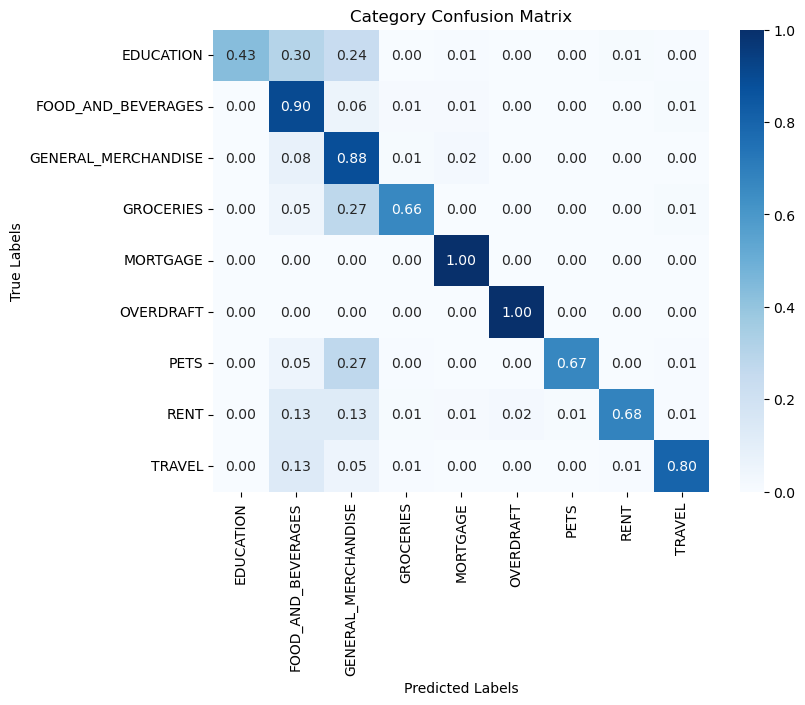

In [22]:
metrics(y_train, X_train.pred)

                     precision    recall  f1-score   support

          EDUCATION       0.46      0.41      0.44      1341
 FOOD_AND_BEVERAGES       0.85      0.90      0.88    141846
GENERAL_MERCHANDISE       0.82      0.86      0.84    153494
          GROCERIES       0.93      0.64      0.76     65587
           MORTGAGE       0.06      0.99      0.11       357
          OVERDRAFT       0.66      1.00      0.79       818
               PETS       0.66      0.62      0.64      2700
               RENT       0.40      0.58      0.48      1106
             TRAVEL       0.88      0.79      0.83     16947

           accuracy                           0.83    384196
          macro avg       0.64      0.75      0.64    384196
       weighted avg       0.85      0.83      0.83    384196



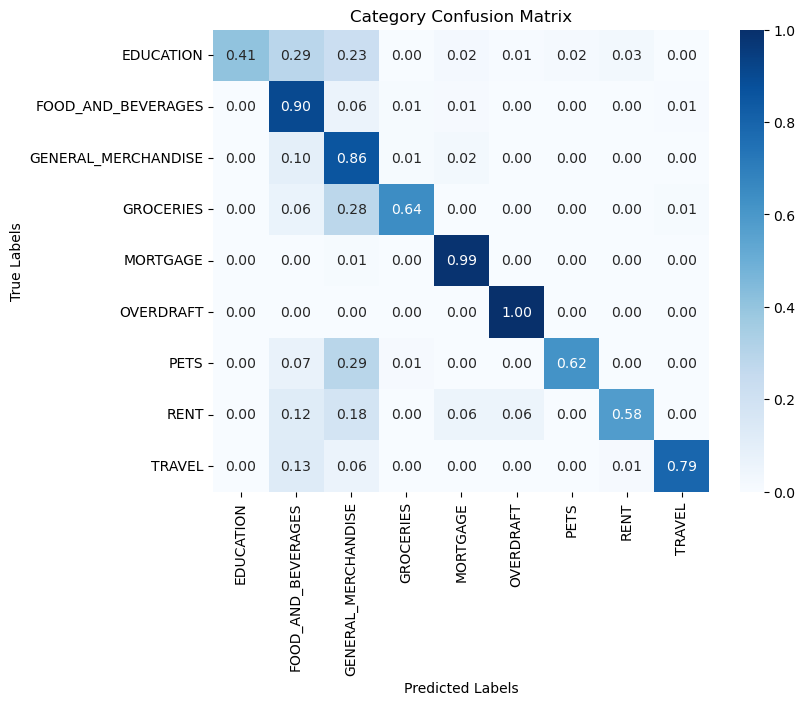

In [23]:
metrics(y_test, X_test.pred)

## Boosting Approach:

- Using simple learner such as Logistic Regression:

In [ ]:
base_estimator = LogisticRegression(solver='sag')

booster = Pipeline([
    ('preprocessor', preproc),
    ('booster', AdaBoostClassifier(estimator=base_estimator, n_estimators=50, algorithm='SAMME', random_state=42069))
])

booster.fit(X_train, y_train)
y_pred = booster.predict(X_train)

In [ ]:
metrics(y_train, y_pred)

In [ ]:
y_pred = booster.predict(X_test)

In [ ]:
metrics(y_test, y_pred)

## RoBERTa (Fine-Tuning)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model     = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=9)

In [ ]:
def tokenize_data(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
train_data = Dataset.from_dict({"text": X_train.new_memo, "label": y_train})
test_data = Dataset.from_dict({"text": X_test.new_memo, "label": y_test})

train_data = train_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",        # Still evaluate every epoch, if desired
    save_strategy="no",           # Disable checkpoint saving
    num_train_epochs=5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

trainer.compute_metrics = compute_metrics
trainer.evaluate()